Saving image 1.jpeg to image 1 (1).jpeg


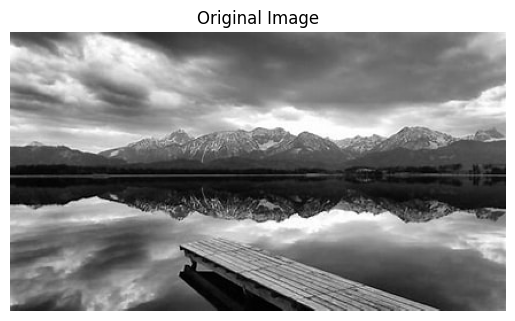

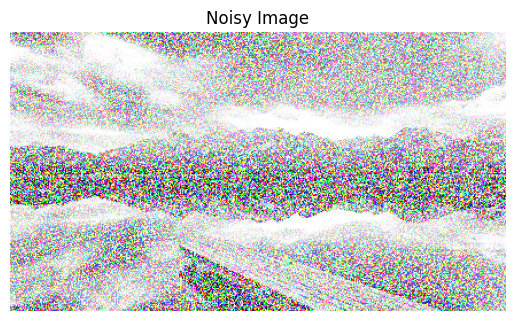

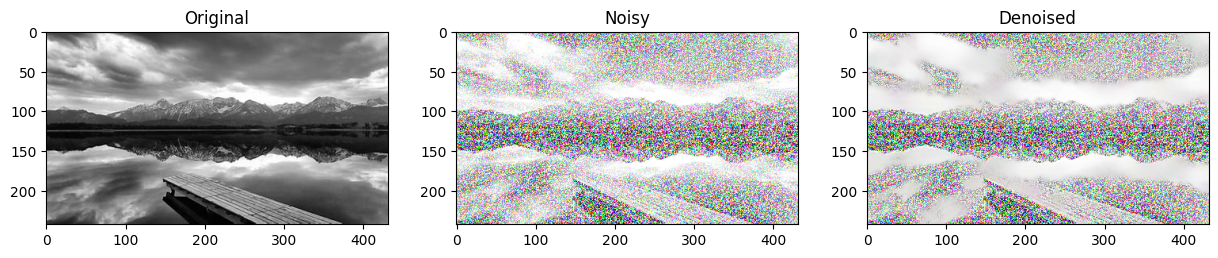

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded))
img = cv2.imread(image_path)

# Convert to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Add some synthetic noise to the image (skip this if your uploaded image already has noise)
noisy_img = img.copy()
noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
noisy_img = cv2.add(img, noise)

plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
plt.title('Noisy Image')
plt.axis('off')
plt.show()

# Denoising using OpenCV's fastNlMeansDenoisingColored
denoised_img = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)), plt.title('Noisy')
plt.subplot(133), plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB)), plt.title('Denoised')
plt.show()


📸 Upload at least 2 overlapping images for panorama stitching:


Saving i3.png to i3 (1).png
Saving i 2.png to i 2 (1).png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


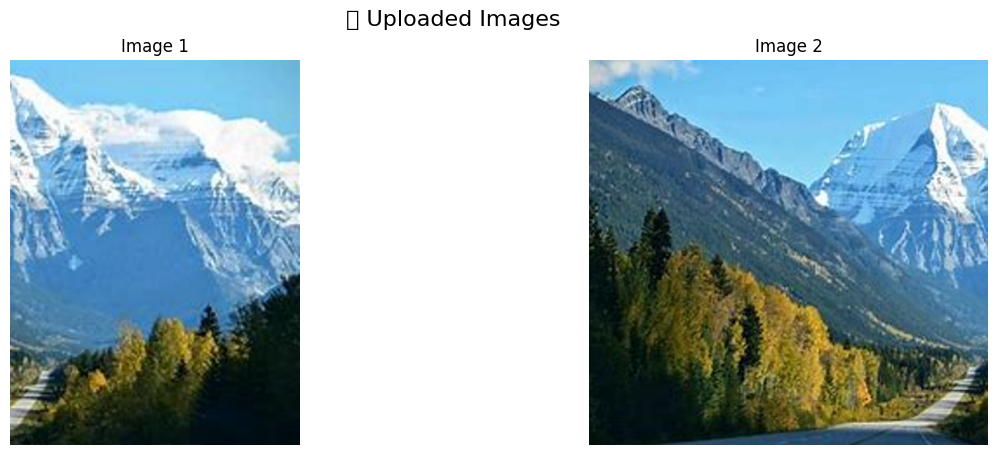

🔧 Stitching in progress...
❌ Stitching failed. Status code: 1
ERR_NEED_MORE_IMGS — Need at least 2 images with sufficient overlap.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
print("📸 Upload at least 2 overlapping images for panorama stitching:")
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Check at least 2 images are uploaded
if len(image_paths) < 2:
    raise ValueError("❌ Please upload at least 2 images with overlap.")

# Read and store images
images = []
plt.figure(figsize=(15, 5))
for i, path in enumerate(image_paths, 1):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"❌ Couldn't load image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, len(image_paths), i)
    plt.imshow(img)
    plt.title(f'Image {i}')
    plt.axis('off')
plt.suptitle("🔍 Uploaded Images", fontsize=16)
plt.show()

# Create OpenCV Stitcher object
try:
    stitcher = cv2.Stitcher_create()  # For OpenCV 4.x
except:
    stitcher = cv2.createStitcher(False)  # For OpenCV 3.x

# Stitch the images
print("🔧 Stitching in progress...")
(status, stitched) = stitcher.stitch(images)

# Check result
if status == cv2.Stitcher_OK:
    print("✅ Stitching successful!")
    plt.figure(figsize=(15, 7))
    plt.imshow(stitched)
    plt.title("🧵 Stitched Panorama")
    plt.axis('off')
    plt.show()
else:
    print(f"❌ Stitching failed. Status code: {status}")
    error_messages = {
        1: "ERR_NEED_MORE_IMGS — Need at least 2 images with sufficient overlap.",
        2: "ERR_HOMOGRAPHY_EST_FAIL — Could not find enough matches between images.",
        3: "ERR_CAMERA_PARAMS_ADJUST_FAIL — Camera parameters could not be estimated."
    }
    print(error_messages.get(status, "Unknown error occurred."))



In [ ]:
# ===================================
# Task 2: Image Restoration using Autoencoder
# ===================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr

# ========== 1. Load & Preprocess Data ==========
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add channel dimension (for Conv2D)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# ========== 2. Simulate Degradation ==========
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_noise(x_train, noise_factor=0.5)
x_test_noisy = add_noise(x_test, noise_factor=0.5)

# ========== 3. Build the Autoencoder ==========
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder((28,28,1))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# ========== 4. Train the Model ==========
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=50,  # 50 epochs minimum as per your requirement
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

# ========== 5. Image Restoration & Evaluation ==========
# Predict restored images
restored_imgs = autoencoder.predict(x_test_noisy)

# Function to display images
def show_images(original, noisy, restored, n=10):
    plt.figure(figsize=(20,6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28,28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28,28), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        # Restored
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(restored[i].reshape(28,28), cmap='gray')
        plt.title('Restored')
        plt.axis('off')
    plt.show()

# Show comparison
show_images(x_test, x_test_noisy, restored_imgs)

# Calculate PSNR for evaluation
total_psnr = 0
for i in range(len(x_test)):
    total_psnr += psnr(x_test[i].squeeze(), restored_imgs[i].squeeze(), data_range=1.0)

average_psnr = total_psnr / len(x_test)
print(f"\nAverage PSNR on test set: {average_psnr:.2f} dB")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 377ms/step - loss: 0.1167 - val_loss: 0.1140
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 377ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 372ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 377ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 378ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 373ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 374ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 8/50
123/469 ━━━━━━━━━━━━━━━━━━━━ 2:01 353ms/step - loss: 0.1118

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-c6e2916f15bc>", line 59, in <cell line: 0>
    history = autoencoder.fit(x_train_noisy, x_train,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
    opt_outputs = multi_step_on_iterator(iterator)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tens

TypeError: object of type 'NoneType' has no len()